In [4]:
from pathlib import Path
import re, numpy as np, pandas as pd, mne
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("ERROR")

In [5]:
import sys, importlib.util, os
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath))  

In [6]:
DATA = Path(f"{parentPath}/data")
DER  = DATA / "derivatives"  
FIGS = Path(f"{parentPath}/figs"); FIGS.mkdir(parents=True, exist_ok=True)

In [8]:
# paths = sorted(DER.glob("*-aligned128-epo.fif")) # all at 128 Hz, same tmin/tmax #or sorted(DER.glob("*-epo.fif"))
paths = sorted(DER.glob("*-epo.fif"))

# paths = [p for p in paths if re.search(r"R(03|04|07|08|11|12)", p.name)] # only these subjects have both L and R hand MI
# paths = [p for p in paths if re.search(r"R(04|08|12)", p.name)]  # L/R imagery only
paths = [p for p in paths if re.search(r"R(03|07|11)", p.name)]  # L/R exec only
# paths = [p for p in paths if re.search(r"R(06|10|14)", p.name)]  # both imagery only

print("Files:", len(paths))


Files: 318


In [9]:
X_list, y_list, runs, chs , subjs= [], [], [], None, []
for p in paths:
    ep = mne.read_epochs(p, preload=True, verbose=False)
    if len(ep)==0: continue
    if chs is None: chs = ep.ch_names
    X_list.append(ep.get_data())       # (n_ep, n_ch, n_t)
    y_list.append(ep.events[:, -1])    # (n_ep,)
    run = int(re.search(r"R(\d{2})", p.name).group(1)); runs.extend([run]*len(ep))
    subj_name = re.search(r"(S\d{3})", p.name).group(1); subj_number = int(subj_name.lstrip("S"))
    subjs.extend([subj_number] * len(ep))

X = np.concatenate(X_list, axis=0); y = np.concatenate(y_list); runs = np.array(runs); subjs = np.array(subjs)
print("Raw epochs cube:", X.shape, "labels:", np.unique(y), "runs:", np.unique(runs), "subjects:", np.unique(subjs))


Raw epochs cube: (1266, 64, 161) labels: [1 2] runs: [ 3  7 11] subjects: [  1   2   4   6   7   8  10  11  12  14  16  18  20  25  26  29  30  31
  33  34  35  37  40  41  42  44  45  47  50  51  55  57  59  62  63  64
  66  67  71  72  73  74  76  78  80  81  82  85  87  89  93  98 102 104
 105 107 108]


In [10]:
from mne.decoding import CSP

def eval_csp_singleband(X, y, runs, fmin=8, fmax=30, n_csp=6, clf="lda", n_splits=3):
    gkf = GroupKFold(n_splits=min(n_splits, np.unique(runs).size))
    metrics = []
    cms = []
    for fold, (tr, te) in enumerate(gkf.split(X, y, runs)):
        # bandpass (fit on raw arrays via MNE filter on-the-fly)
        Xtr = mne.filter.filter_data(X[tr].transpose(0,2,1), sfreq=128, l_freq=fmin, h_freq=fmax, verbose=False).transpose(0,2,1)
        Xte = mne.filter.filter_data(X[te].transpose(0,2,1), sfreq=128, l_freq=fmin, h_freq=fmax, verbose=False).transpose(0,2,1)

        csp = CSP(n_components=n_csp, reg='ledoit_wolf', log=True, norm_trace=False)
        csp.fit(Xtr, y[tr])
        Ztr, Zte = csp.transform(Xtr), csp.transform(Xte)

        if clf=="lda":
            cls = LDA()
        else:
            cls = LogisticRegression(max_iter=2000, class_weight="balanced")
        cls.fit(Ztr, y[tr]); yhat = cls.predict(Zte)

        metrics.append(dict(
            fold=fold,
            acc=accuracy_score(y[te], yhat),
            kappa=cohen_kappa_score(y[te], yhat),
            f1_macro=f1_score(y[te], yhat, average="macro")
        ))
        cms.append(confusion_matrix(y[te], yhat))
    return pd.DataFrame(metrics), cms, csp


In [12]:
df_csp, cms_csp, csp_model = eval_csp_singleband(X, y, runs, n_csp=6, clf="lda", n_splits=3)
display("CSP 8–30Hz (mean):\n", df_csp.mean(numeric_only=True).round(3))


'CSP 8–30Hz (mean):\n'

fold        1.000
acc         0.568
kappa       0.137
f1_macro    0.568
dtype: float64

In [16]:
# bands for FB-CSP
FB = {"mu1":(8,12), "mu2":(12,16), "beta1":(16,22), "beta2":(22,30)}

def eval_fb_csp(X, y, runs, fb=FB, n_csp=2, clf="lda", n_splits=3, sfreq=128):
    gkf = GroupKFold(n_splits=min(n_splits, np.unique(runs).size))
    metrics, cms = [], []

    for fold, (tr, te) in enumerate(gkf.split(X, y, runs)):
        Ztr_bands, Zte_bands, csps = [], [], {}
        for bname, (lo, hi) in fb.items():
            Xtr = mne.filter.filter_data(X[tr].transpose(0,2,1), sfreq=sfreq, l_freq=lo, h_freq=hi, verbose=False).transpose(0,2,1)
            Xte = mne.filter.filter_data(X[te].transpose(0,2,1), sfreq=sfreq, l_freq=lo, h_freq=hi, verbose=False).transpose(0,2,1)

            csp = CSP(n_components=n_csp, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xtr, y[tr])
            Ztr_bands.append(csp.transform(Xtr))   # (n_tr, 2*n_csp? actually n_csp)
            Zte_bands.append(csp.transform(Xte))
            csps[bname] = csp

        Ztr = np.concatenate(Ztr_bands, axis=1)
        Zte = np.concatenate(Zte_bands, axis=1)

        model = LDA() if clf=="lda" else LogisticRegression(max_iter=2000, class_weight="balanced")
        model.fit(Ztr, y[tr]); yhat = model.predict(Zte)

        metrics.append(dict(
            fold=fold,
            acc=accuracy_score(y[te], yhat),
            kappa=cohen_kappa_score(y[te], yhat),
            f1_macro=f1_score(y[te], yhat, average="macro")
        ))
        cms.append(confusion_matrix(y[te], yhat))
    return pd.DataFrame(metrics), cms


In [17]:
df_fbcsp, cms_fb = eval_fb_csp(X, y, runs, fb=FB, n_csp=2, clf="lda", n_splits=3)
display("FB-CSP (mean):\n", df_fbcsp.mean(numeric_only=True).round(3))


'FB-CSP (mean):\n'

fold        1.0
acc         0.6
kappa       0.2
f1_macro    0.6
dtype: float64

NameError: name 'csp_full' is not defined

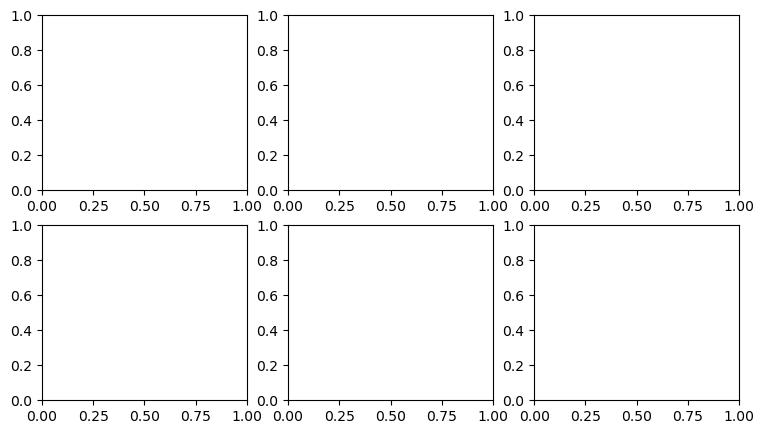

In [ ]:
# 1) clean channel names (EEGBCI often has trailing dots like 'Fc5.')
chs_fixed = [c.rstrip('.') for c in chs]

# 2) build info with a standard montage
mont = mne.channels.make_standard_montage('standard_1020')  # or 'biosemi64' if that's your cap
info = mne.create_info(chs_fixed, sfreq=128., ch_types='eeg')
info.set_montage(mont, match_case=False, on_missing='ignore')  # attach positions

# 3) plot CSP spatial patterns
fig, axes = plt.subplots(2, 3, figsize=(9, 5))
for i, ax in enumerate(axes.ravel()):
    mne.viz.plot_topomap(csp_full.patterns_[i], info, axes=ax, show=False)
    ax.set_title(f"CSP pattern {i+1}")
fig.suptitle("CSP spatial patterns (8–30 Hz)")
fig.tight_layout()
fig.savefig(FIGS / "csp_patterns.png", dpi=150)


In [ ]:
grid = []
for n_csp in [2, 4, 6]:
    for clf in ["lda", "logreg"]:
        df, _, _ = eval_csp_singleband(X, y, runs, fmin=8, fmax=30, n_csp=n_csp, clf=clf, n_splits=3)
        row = dict(model=f"CSP-{clf}", n_csp=n_csp, **df.mean(numeric_only=True).to_dict())
        grid.append(row)

for n_csp in [1, 2, 3]:
    df, _ = eval_fb_csp(X, y, runs, fb=FB, n_csp=n_csp, clf="lda", n_splits=3)
    row = dict(model=f"FB-CSP-lda", n_csp=n_csp, **df.mean(numeric_only=True).to_dict())
    grid.append(row)

grid_df = pd.DataFrame(grid).sort_values("kappa", ascending=False)
print(grid_df.round(3))
grid_df.to_csv(f"{parentPath}results/day5_param_sweep.csv", index=False)


### Subject wise LOSO performance (harder, more realistic)

In [ ]:

logo = LeaveOneGroupOut()
rows = []
for tr, te in logo.split(X, y, groups=subjs):
    # Use FB-CSP tuned config (e.g., n_csp=2)
    Ztr_b, Zte_b = [], []
    for (lo, hi) in FB.values():
        Xtr = mne.filter.filter_data(X[tr].transpose(0,2,1), 128, lo, hi, verbose=False).transpose(0,2,1)
        Xte = mne.filter.filter_data(X[te].transpose(0,2,1), 128, lo, hi, verbose=False).transpose(0,2,1)
        csp = CSP(n_components=2, reg='ledoit_wolf', log=True)
        Ztr_b.append(csp.fit_transform(Xtr, y[tr]))
        Zte_b.append(csp.transform(Xte))
    Ztr, Zte = np.concatenate(Ztr_b, axis=1), np.concatenate(Zte_b, axis=1)
    mdl = LDA().fit(Ztr, y[tr]); yhat = mdl.predict(Zte)
    rows.append(dict(sub_test=subs[te][0],
                     acc=accuracy_score(y[te], yhat),
                     kappa=cohen_kappa_score(y[te], yhat),
                     f1_macro=f1_score(y[te], yhat, average="macro")))
loso_df = pd.DataFrame(rows)
print("LOSO (per subject):\n", loso_df.round(3))
print("LOSO mean:\n", loso_df.mean(numeric_only=True).round(3))
loso_df.to_csv(f"{parentPath}results/day5_loso.csv", index=False)


KeyboardInterrupt: 

### Save one confusion matrix (best config)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
(tr, te), = sss.split(np.zeros_like(y), y)

# Fit best: say FB-CSP (n_csp=2, LDA)
Ztr_b, Zte_b = [], []
for (lo, hi) in FB.values():
    Xtr = mne.filter.filter_data(X[tr].transpose(0,2,1), 128, lo, hi, verbose=False).transpose(0,2,1)
    Xte = mne.filter.filter_data(X[te].transpose(0,2,1), 128, lo, hi, verbose=False).transpose(0,2,1)
    csp = CSP(n_components=2, reg='ledoit_wolf', log=True)
    Ztr_b.append(csp.fit_transform(Xtr, y[tr]))
    Zte_b.append(csp.transform(Xte))
Ztr, Zte = np.concatenate(Ztr_b, axis=1), np.concatenate(Zte_b, axis=1)

mdl = LDA().fit(Ztr, y[tr])
yhat = mdl.predict(Zte)
disp = ConfusionMatrixDisplay.from_predictions(y[te], yhat)
plt.title("FB-CSP (n_csp=2) — CM"); plt.tight_layout()
plt.savefig(FIGS / "day5_fb_csp_cm.png", dpi=150); plt.close()
